# POC for scraping framework

### General idea

There will be three personas:
- Developers
- Analysts
- Devops

Developers will create tools (Python functions). They will define the input and output structures of these tools. The functions will be automatically deployed as separate images in Kubernetes.
Analysts will prompt the system to fetch specific data. The system will pick the required tools and chain tools, if necessary, to get the desired output.

### Work areas:

#### Orchastation engine

The analyst's prompts will be passed to a backend where LLMs will be used to identify the required tools and chain them. This graph should be displayed to the user, who will confirm, and the execution will begin.

Example of analyts prompt could be: 
``` 
Get me all reviews for the products in https://www.amazon.in/s?k=pesticides&crid=2OH7HH2FLCMK6&sprefix=pesticide%2Caps%2C219&ref=nb_sb_noss_2
```

#### Tool development flow

Developers should be able to write tools to a repo in a given format. That repo should be registered in the system. The system will then listen for changes and create docker images for the tools automatically.
There should be logs collected for each tool and run that should be accessible to the developers. 

#### DevOps engineer

The devlops engineer should be able to use the coud specific setup code (infra as code) to easily set up the application in their environments.

---


In [11]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

## Orchastation engine

Create tools which take a single input and create a single output. The inputs and outputs must be a pydantic object.

Below are some dummy tools

In [400]:
import datetime
from typing import List, Optional
from pydantic import BaseModel, Field, HttpUrl
from langchain.tools import StructuredTool

# --- Amazon Structures ---

class AmazonProductScraperInputs(BaseModel):
    product_url: HttpUrl = Field(
        ...,
        description="Amazon product URL. Example: https://www.amazon.com/dp/B09B2SBHQK or https://www.amazon.in/dp/B0BY8MXBPM"
    )

class AmazonProduct(BaseModel):
    title: str = Field(..., description="Product title")
    url: HttpUrl = Field(
        ...,
        description="Canonical Amazon product URL. Example: https://www.amazon.com/dp/B09B2SBHQK"
    )
    image_urls: List[HttpUrl] = Field(
        ...,
        description="List of product image URLs. Example: ['https://m.media-amazon.com/images/I/71xb2xkN5qL._AC_SL1500_.jpg']"
    )
    price: float = Field(..., description="Pricing details of the product")
    rating: Optional[float] = Field(None, description="Product rating (0-5)")
    review_count: Optional[int] = Field(0, description="Number of reviews")
    availability: Optional[str] = Field(None, description="Product availability status (e.g., 'In Stock', 'Currently unavailable')")
    features: Optional[List[str]] = Field(None, description="List of key product features (often bullet points)")
    seller: Optional[str] = Field(None, description="Seller name (e.g., 'Amazon.com', 'Sold by X, Fulfilled by Amazon')")
    asin: str = Field(..., description="Amazon Standard Identification Number (ASIN)")

class AmazonPLPInputs(BaseModel):
    product_url: HttpUrl = Field(
        ...,
        description="""Amazon product listing page URL (search results, category/browse node).
        Example .com Search URL: https://www.amazon.com/s?k=echo+dot
        Example .com Browse Node URL: https://www.amazon.com/gp/browse.html?node=172282
        Example .in Search URL: https://www.amazon.in/s?k=smartphones&ref=nb_sb_noss_2
        Example .in Browse Node URL: https://www.amazon.in/gp/browse.html?node=1389401031"""
    )
    max_count: Optional[int] = Field(None, description="Limit the number of products that are returned")

class AmazonPLPItem(BaseModel):
    url: HttpUrl = Field(
        ...,
        description="URL of the Amazon product found on the listing page. Example: https://www.amazon.com/dp/B09B2SBHQK"
    )

def amazon_product_scraper(item:AmazonProductScraperInputs) -> AmazonProduct:
    """
    Scraper to fetch a product's information from the product page of Amazon.
    """
    return AmazonProduct(
        title="Echo Dot (5th Gen, 2022 release) | Smart speaker with Alexa | Charcoal",
        url="https://www.amazon.com/dp/B09B2SBHQK", # Example URL
        image_urls=["https://m.media-amazon.com/images/I/71xb2xkN5qL._AC_SL1500_.jpg"], # Example URL
        price=49.99,
        rating=4.7,
        review_count=156000,
        availability="In Stock",
        features=["Our best sounding Echo Dot yet", "Control music with your voice", "Ask Alexa for weather, news, timers, etc.", "Control compatible smart home devices"],
        seller="Amazon.com",
        asin="B09B2SBHQK" # Matches example URL
    )

def amazon_plp_scraper(item:AmazonPLPInputs) -> List[AmazonPLPItem]:
    """
    Scraper to fetch all products from an Amazon product listing page.
    """
    return [
        AmazonPLPItem(url="https://www.amazon.com/dp/B09B2SBHQK"), # Example URL 1
        AmazonPLPItem(url="https://www.amazon.com/dp/B09B2SWS7B")  # Example URL 2 (different color maybe)
        ]

# --- Walmart Structures ---

class WalmartProductScraperInputs(BaseModel):
    product_url: HttpUrl = Field(
        ...,
        description="Walmart product URL. Example: https://www.walmart.com/ip/onn-Android-TV-4K-UHD-Streaming-Device-with-Voice-Remote-Control-HDMI-Cable/606421073"
    )

class WalmartProduct(BaseModel):
    title: str = Field(..., description="Product title")
    url: HttpUrl = Field(
        ...,
        description="Canonical Walmart product URL. Example: https://www.walmart.com/ip/onn-Android-TV-4K-UHD-Streaming-Device-with-Voice-Remote-Control-HDMI-Cable/606421073"
    )
    image_urls: List[HttpUrl] = Field(
        ...,
        description="List of product image URLs. Example: ['https://i5.walmartimages.com/seo/onn-Android-TV-4K-UHD-Streaming-Device-with-Voice-Remote-Control-HDMI-Cable_bfc53150-8b17-4644-b94d-f66b3a7de9e2.1a0c28b08e4b4049aa7aad7d339b1db1.jpeg']"
    )
    price: float = Field(..., description="Pricing details of the product")
    rating: Optional[float] = Field(None, description="Product rating (0-5)")
    review_count: Optional[int] = Field(0, description="Number of reviews")
    availability: Optional[str] = Field(None, description="Product availability status")
    features: Optional[List[str]] = Field(None, description="List of key product features")
    seller: Optional[str] = Field(None, description="Seller name (e.g., 'Walmart', 'Sold and shipped by...')")
    item_id: str = Field(..., description="Walmart Item ID or Product ID")

class WalmartPLPInputs(BaseModel):
    product_url: HttpUrl = Field(
        ...,
        description="""Walmart product listing page URL (e.g., search results, category page).
        Example Search URL: https://www.walmart.com/search?q=laptop
        Example Category URL: https://www.walmart.com/browse/electronics/tvs/1060825_1071960"""
    )
    max_count: Optional[int] = Field(None, description="Limit the number of products that are returned")

class WalmartPLPItem(BaseModel):
    url: HttpUrl = Field(
        ...,
        description="URL of the Walmart product found on the listing page. Example: https://www.walmart.com/ip/onn-4K-Pro-Streaming-Device-Google-TV-Hands-Free-Voice-Control-Find-My-Remote/5094809539"
    )

def walmart_product_scraper(item: WalmartProductScraperInputs) -> WalmartProduct:
    """
    Scraper to fetch a product's information from the product page of Walmart.
    """
    return WalmartProduct(
        title="onn. Android TV 4K UHD Streaming Device with Voice Remote Control & HDMI Cable",
        url="https://www.walmart.com/ip/onn-Android-TV-4K-UHD-Streaming-Device-with-Voice-Remote-Control-HDMI-Cable/606421073",
        image_urls=["https://i5.walmartimages.com/seo/onn-Android-TV-4K-UHD-Streaming-Device-with-Voice-Remote-Control-HDMI-Cable_bfc53150-8b17-4644-b94d-f66b3a7de9e2.1a0c28b08e4b4049aa7aad7d339b1db1.jpeg"],
        price=19.88,
        rating=4.5,
        review_count=6400,
        availability="In stock",
        features=["4K Ultra High-Definition resolution", "Wi-Fi: 2.4/5GHz 802.11 a/b/g/n/ac MIMO", "Android TV OS", "Google Assistant built-in"],
        seller="Sold and shipped by Walmart",
        item_id="606421073"
    )

def walmart_plp_scraper(item: WalmartPLPInputs) -> List[WalmartPLPItem]:
    """
    Scraper to fetch all products from a Walmart product listing page.
    """
    return [
        WalmartPLPItem(url="https://www.walmart.com/ip/onn-Android-TV-4K-UHD-Streaming-Device-with-Voice-Remote-Control-HDMI-Cable/606421073"),
        WalmartPLPItem(url="https://www.walmart.com/ip/onn-4K-Pro-Streaming-Device-Google-TV-Hands-Free-Voice-Control-Find-My-Remote/5094809539")
    ]

# --- Target Structures ---

class TargetProductScraperInputs(BaseModel):
    product_url: HttpUrl = Field(
        ...,
        description="Target product URL. Example: https://www.target.com/p/apple-ipad-10-9-inch-wi-fi-64gb-silver/-/A-87464948"
    )

class TargetProduct(BaseModel):
    title: str = Field(..., description="Product title")
    url: HttpUrl = Field(
        ...,
        description="Canonical Target product URL. Example: https://www.target.com/p/apple-ipad-10-9-inch-wi-fi-64gb-silver/-/A-87464948"
    )
    image_urls: List[HttpUrl] = Field(
        ...,
        description="List of product image URLs. Example: ['https://target.scene7.com/is/image/Target/GUEST_f3d138a9-9f8f-46ae-9da3-e427b3d6aba2?wid=800&hei=800&qlt=80&fmt=webp']"
    )
    price: float = Field(..., description="Pricing details of the product")
    rating: Optional[float] = Field(None, description="Product rating (usually 0-5)")
    review_count: Optional[int] = Field(0, description="Number of reviews")
    availability: Optional[str] = Field(None, description="Product availability status (e.g., 'In stock', 'Out of stock', 'Ship it', 'Pick it up')")
    features: Optional[List[str]] = Field(None, description="List of key product features or highlights")
    seller: Optional[str] = Field("Target", description="Usually 'Target' or 'Sold and shipped by Target'")
    tcin: str = Field(..., description="Target Category ID Number (TCIN)")

class TargetPLPInputs(BaseModel):
    product_url: HttpUrl = Field(
        ...,
        description="""Target product listing page URL (e.g., search results, category page).
        Example Search URL: https://www.target.com/s?searchTerm=coffee+maker
        Example Category URL: https://www.target.com/c/kitchen-dining/-/N-5xtrz"""
    )
    max_count: Optional[int] = Field(None, description="Limit the number of products that are returned")

class TargetPLPItem(BaseModel):
    url: HttpUrl = Field(
        ...,
        description="URL of the Target product found on the listing page. Example: https://www.target.com/p/keurig-k-mini-single-serve-k-cup-pod-coffee-maker/-/A-53790797"
    )

def target_product_scraper(item: TargetProductScraperInputs) -> TargetProduct:
    """
    Scraper to fetch a product's information from the product page of Target.
    """
    return TargetProduct(
        title="Apple iPad 10.9-inch Wi-Fi (2022, 10th Generation)",
        url="https://www.target.com/p/apple-ipad-10-9-inch-wi-fi-64gb-silver/-/A-87464948",
        image_urls=["https://target.scene7.com/is/image/Target/GUEST_f3d138a9-9f8f-46ae-9da3-e427b3d6aba2?wid=800&hei=800&qlt=80&fmt=webp"],
        price=449.99,
        rating=4.6,
        review_count=850,
        availability="Ship it",
        features=["Striking 10.9-inch Liquid Retina display", "A14 Bionic chip", "12MP Wide back camera", "Landscape 12MP Ultra Wide front camera"],
        seller="Target",
        tcin="87464948"
    )

def target_plp_scraper(item: TargetPLPInputs) -> List[TargetPLPItem]:
    """
    Scraper to fetch all products from a Target product listing page.
    """
    return [
        TargetPLPItem(url="https://www.target.com/p/apple-ipad-10-9-inch-wi-fi-64gb-silver/-/A-87464948"),
        TargetPLPItem(url="https://www.target.com/p/keurig-k-mini-single-serve-k-cup-pod-coffee-maker/-/A-53790797")
    ]

# --- Twitter Structures ---

class TwitterTweetScraperInputs(BaseModel):
    tweet_url: HttpUrl = Field(
        ...,
        description="URL of the specific Tweet. Example: https://twitter.com/SpaceX/status/1775965705031479537 or https://x.com/SpaceX/status/1775965705031479537"
    )

class Tweet(BaseModel):
    text: str = Field(..., description="The main content/text of the Tweet")
    url: HttpUrl = Field(
        ...,
        description="Canonical URL of the Tweet. Example: https://twitter.com/SpaceX/status/1775965705031479537"
    )
    author_username: str = Field(..., description="Username/handle of the Tweet author (e.g., @SpaceX)")
    author_name: Optional[str] = Field(None, description="Display name of the Tweet author (e.g., SpaceX)")
    timestamp: datetime.datetime = Field(..., description="Date and time the Tweet was posted")
    likes: Optional[int] = Field(None, description="Number of likes")
    retweets: Optional[int] = Field(None, description="Number of retweets/reposts")
    replies: Optional[int] = Field(None, description="Number of replies")
    media_urls: Optional[List[HttpUrl]] = Field(
        None,
        description="List of URLs for attached media (images, videos). Example: ['https://pbs.twimg.com/media/GKVTkUgXoAAXCm2?format=jpg&name=large']"
    )
    tweet_id: str = Field(..., description="Unique ID of the Tweet")

# Note: A "PLP" equivalent for Twitter might be search results or a user's timeline.
# Let's model a search scraper.
class TwitterSearchScraperInputs(BaseModel):
    search_query: str = Field(..., description="Search query string for Twitter (e.g., '#AI', 'from:googleai')")
    max_count: Optional[int] = Field(None, description="Limit the number of tweets that are returned")

class TwitterSearchItem(BaseModel):
    tweet_url: HttpUrl = Field(
        ...,
        description="URL of a Tweet found in the search results. Example: https://twitter.com/GoogleAI/status/1775210244816888182"
    )

# def twitter_tweet_scraper(item: TwitterTweetScraperInputs) -> Tweet:
def twitter_tweet_scraper(item: List[TwitterTweetScraperInputs]) -> Tweet:
    """
    Scraper to fetch information about a single Tweet from its URL.
    """
    # Use a fixed past datetime for the dummy data for consistency
    dummy_timestamp = datetime.datetime(2025, 4, 4, 14, 30, 0, tzinfo=datetime.timezone.utc)

    return Tweet(
        text="Falcon 9 launches 23 @Starlink satellites to orbit from Florida",
        url="https://twitter.com/SpaceX/status/1775965705031479537",
        author_username="@SpaceX",
        author_name="SpaceX",
        timestamp=dummy_timestamp,
        likes=15200,
        retweets=2100,
        replies=550,
        media_urls=["https://pbs.twimg.com/media/GKVTkUgXoAAXCm2?format=jpg&name=large"],
        tweet_id="1775965705031479537"
    )

def twitter_search_scraper(item: TwitterSearchScraperInputs) -> List[TwitterSearchItem]:
    """
    Scraper to fetch Tweet URLs from a Twitter search results page.
    """
    return [
        TwitterSearchItem(tweet_url="https://twitter.com/GoogleAI/status/1775210244816888182"),
        TwitterSearchItem(tweet_url="https://twitter.com/OpenAI/status/1775197560445178113")
    ]


Below is a list of all dummy tools. We will convert them to openai tools to help store them in a database. 

In [443]:
import inspect
from langchain_core.utils.function_calling import convert_to_openai_tool
tool_list = [amazon_product_scraper, amazon_plp_scraper, walmart_product_scraper, walmart_plp_scraper, target_product_scraper, target_plp_scraper, twitter_tweet_scraper, twitter_search_scraper]

def get_output_details_for_tool(tool):
    signature = inspect.signature(tool)
    return_annotation = signature.return_annotation

    # Check if the return annotation is a generic type like List[Model]
    origin = typing.get_origin(return_annotation)
    if origin is list or origin is List: # Handles both list and typing.List
        args = typing.get_args(return_annotation)
        if args:
            inner_type = args[0]
            # Check if the inner type is a Pydantic model
            if inspect.isclass(inner_type) and issubclass(inner_type, BaseModel):
                return inner_type.model_json_schema()
    # Optional: Handle case where the function returns a single Pydantic model directly
    elif inspect.isclass(return_annotation) and issubclass(return_annotation, BaseModel):
        return return_annotation.model_json_schema()
    raise Exception("Could not determine output format of tool")

tool_details = []
for i in tool_list:
    tool_details.append({
        "openai_spec": convert_to_openai_tool(i),
        "output_details": get_output_details_for_tool(i)
    })

In [445]:
for i in tool_details:
    print(i['output_details'])
    print()

{'properties': {'title': {'description': 'Product title', 'title': 'Title', 'type': 'string'}, 'url': {'description': 'Canonical Amazon product URL. Example: https://www.amazon.com/dp/B09B2SBHQK', 'format': 'uri', 'maxLength': 2083, 'minLength': 1, 'title': 'Url', 'type': 'string'}, 'image_urls': {'description': "List of product image URLs. Example: ['https://m.media-amazon.com/images/I/71xb2xkN5qL._AC_SL1500_.jpg']", 'items': {'format': 'uri', 'maxLength': 2083, 'minLength': 1, 'type': 'string'}, 'title': 'Image Urls', 'type': 'array'}, 'price': {'description': 'Pricing details of the product', 'title': 'Price', 'type': 'number'}, 'rating': {'anyOf': [{'type': 'number'}, {'type': 'null'}], 'default': None, 'description': 'Product rating (0-5)', 'title': 'Rating'}, 'review_count': {'anyOf': [{'type': 'integer'}, {'type': 'null'}], 'default': 0, 'description': 'Number of reviews', 'title': 'Review Count'}, 'availability': {'anyOf': [{'type': 'string'}, {'type': 'null'}], 'default': None

Set the OPENAI api key if not present in the environment

In [426]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

Set up gpt 4 model with tools

In [427]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([i['openai_spec'] for i in tool_details], parallel_tool_calls=False)

In [134]:

#input from human
messages = [HumanMessage(content="Can you get me ratings data from https://www.amazon.in/gp/browse.html?node=1968126031&ref_=nav_em_sbc_mfashion_innerwear_0_2_10_6 a 100 products should do",name="Puneet")]

In [135]:
message = llm_with_tools.invoke(messages)

In [164]:
message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_AEB9qv0GS9yY6sRqw2B5X1yD', 'function': {'arguments': '{"item":{"product_url":"https://www.amazon.in/gp/browse.html?node=1968126031&ref_=nav_em_sbc_mfashion_innerwear_0_2_10_6"}}', 'name': 'amazon_plp_scraper'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 56, 'prompt_tokens': 286, 'total_tokens': 342, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_6dd05565ef', 'id': 'chatcmpl-BIEAg0WKHm9lWd7UURQjTpZJZq7Uo', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-172f2be9-e2f0-454d-bd1a-0291708b3485-0', tool_calls=[{'name': 'amazon_plp_scraper', 'args': {'item': {'product_url': 'https://www.amazon.in/gp/browse.html?node=1968126031&ref_=nav_em_sbc_mfas

In [138]:
messages.append(message)

In [172]:
tool_name = messages[-1].tool_calls[0]['name']

In [173]:
tool_function_object = globals().get(tool_name)

In [181]:
tool_function_object

<function __main__.amazon_plp_scraper(item: __main__.AmazonPLPInputs) -> List[__main__.AmazonPLPItem]>

In [177]:
import inspect
signature = inspect.signature(tool_function_object)

In [180]:
print(signature.parameters)
print(signature.return_annotation)

OrderedDict([('item', <Parameter "item: __main__.AmazonPLPInputs">)])
typing.List[__main__.AmazonPLPItem]


In [182]:
type(signature.parameters)

mappingproxy

In [210]:
import typing
return_annotation = signature.return_annotation

# Check if the return annotation is a generic type like List[Model]
origin = typing.get_origin(return_annotation)
if origin is list or origin is List: # Handles both list and typing.List
    args = typing.get_args(return_annotation)
    if args:
        inner_type = args[0]
        # Check if the inner type is a Pydantic model
        if inspect.isclass(inner_type) and issubclass(inner_type, BaseModel):
            output_model = inner_type
# Optional: Handle case where the function returns a single Pydantic model directly
elif inspect.isclass(return_annotation) and issubclass(return_annotation, BaseModel):
    output_model = return_annotation

In [212]:
output_schema = output_model.model_json_schema()

In [200]:
input_schema = signature.parameters[next(iter(signature.parameters))].annotation.model_json_schema()

In [214]:
output_schema

{'properties': {'url': {'description': 'URL of the amazon product',
   'format': 'uri',
   'maxLength': 2083,
   'minLength': 1,
   'title': 'Url',
   'type': 'string'}},
 'required': ['url'],
 'title': 'AmazonPLPItem',
 'type': 'object'}

In [155]:
a = '''
Create a dummy output for the tool amazon_plp_scraper 

the function's input schema is

'''+json.dumps(input_schema)+"""

and  output schema is

"""+json.dumps(output_schema)+"""

please only provide the output in json format
"""

In [156]:
pprint(a)

('\n'
 'Create a dummy output for the tool amazon_plp_scraper \n'
 '\n'
 "the function's input schema is\n"
 '\n'
 '{"properties": {"product_url": {"description": "Amazon product listing page '
 'URL.\\n    Example URLS are: \\n    '
 'https://www.amazon.in/s?k=pesticides&crid=2OH7HH2FLCMK6&sprefix=pesticide%2Caps%2C219&ref=nb_sb_noss_2\\n    '
 'https://www.amazon.in/gp/browse.html?node=1389401031&ref_=nav_em_sbc_mobcomp_all_mobiles_0_2_8_2", '
 '"format": "uri", "maxLength": 2083, "minLength": 1, "title": "Product Url", '
 '"type": "string"}, "max_count": {"anyOf": [{"type": "integer"}, {"type": '
 '"null"}], "default": null, "description": "Limit the number of products that '
 'are returned", "title": "Max Count"}}, "required": ["product_url"], "title": '
 '"AmazonPLPInputs", "type": "object"}\n'
 '\n'
 'and  output schema is\n'
 '\n'
 '{"properties": {"url": {"description": "URL of the amazon product", '
 '"format": "uri", "maxLength": 2083, "minLength": 1, "title": "Url", "type": 

In [157]:
temp = llm.invoke(a)

In [158]:
temp

AIMessage(content='```json\n{\n  "url": "https://www.amazon.in/dp/B08N5WRWNW"\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 330, 'total_tokens': 357, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_6dd05565ef', 'id': 'chatcmpl-BIEDKnOkLcPaqMDCP3mRaMBlcONfs', 'finish_reason': 'stop', 'logprobs': None}, id='run-b63c475e-89a4-43bc-b42c-3fe108cc8ae3-0', usage_metadata={'input_tokens': 330, 'output_tokens': 27, 'total_tokens': 357, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [159]:
from langchain_core.messages import AIMessage, ToolMessage, SystemMessage
tool_call_name = messages[-1].tool_calls[0]["name"]
tool_call_id = messages[-1].tool_calls[0]["id"]
tool_message = ToolMessage(name=tool_call_name, content=temp.content, tool_call_id=tool_call_id)

In [160]:
temp.content

'```json\n{\n  "url": "https://www.amazon.in/dp/B08N5WRWNW"\n}\n```'

In [161]:
messages_test = [messages[0], messages[1], tool_message]

In [162]:
messages_test

[HumanMessage(content='Can you get me ratings data from https://www.amazon.in/gp/browse.html?node=1968126031&ref_=nav_em_sbc_mfashion_innerwear_0_2_10_6 a 100 products should do', additional_kwargs={}, response_metadata={}, name='Puneet'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_AEB9qv0GS9yY6sRqw2B5X1yD', 'function': {'arguments': '{"item":{"product_url":"https://www.amazon.in/gp/browse.html?node=1968126031&ref_=nav_em_sbc_mfashion_innerwear_0_2_10_6"}}', 'name': 'amazon_plp_scraper'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 56, 'prompt_tokens': 286, 'total_tokens': 342, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_6dd05565ef', 'id': 'chatcmpl-BIEAg0WKHm9lWd7UURQjTpZJZq7Uo', 'finish_

In [163]:
llm_with_tools.invoke(messages_test)

AIMessage(content='I have the URL of a product from the Amazon listing page. Here it is: [Link to Product](https://www.amazon.in/dp/B08N5WRWNW). To get detailed ratings data, I will need to scrape the product page for this item. Let me do that for you.', additional_kwargs={'tool_calls': [{'id': 'call_7jzgpOCWyAi5dOgkXXFL4cZP', 'function': {'arguments': '{"item":{"product_url":"https://www.amazon.in/dp/B08N5WRWNW"}}', 'name': 'amazon_product_scraper'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 97, 'prompt_tokens': 378, 'total_tokens': 475, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_6dd05565ef', 'id': 'chatcmpl-BIEDqGXqYkqvWhqVJlmZpsPrH5X1L', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-316c71ff-5b88-4

In [127]:
##Calling the required scraper directly

llm_with_tools.invoke("Can you get me the rating data for this product https://www.amazon.in/Hugo-Boss-Commissioner-Analog-Watch-1513833/dp/B08X4M3VDP/ref=sr_1_1?dib=eyJ2IjoiMSJ9.X7TwV6yg-QF2R1VXJlr1_USbhBi0WoMUWyptiBNnhOm88jR8kdbFK3T0ZjpSvg-CYlYWfgiJ5_sQoGToqoO_w0BJFfCk7xtiwx8uxxWUlpauwX_lsOVhOkruhzwR6iisUYmPlytzBpb0-JKbcOhJT7yKqTHSZqZY8dWv5kxDX-J3FM7ctiO03cwsTHhTjSFpD9UhRbV3inD9bKMd88M1rfKRs-Mro6vg0ECqKoULtmY1P2vA5lmEfXbqXCF4yK4eYaq-9Gp9z3MLW3jaHWTKWqMFKXGgvq0ZaDU6LuAWyIM.qpxL4z7S4A_pwCUgmPfgt5P8I75qfQOfq8girTsYREM&dib_tag=se&pf_rd_i=2563504031&pf_rd_m=A1VBAL9TL5WCBF&pf_rd_s=merchandised-search-12&qid=1743683862&refinements=p_89%3ABOSS&rnid=3837712031&s=watches&sr=1-1")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZgYU9kkYt0kgvh12Tnr6XhiX', 'function': {'arguments': '{"item":{"product_url":"https://www.amazon.in/Hugo-Boss-Commissioner-Analog-Watch-1513833/dp/B08X4M3VDP/ref=sr_1_1?dib=eyJ2IjoiMSJ9.X7TwV6yg-QF2R1VXJlr1_USbhBi0WoMUWyptiBNnhOm88jR8kdbFK3T0ZjpSvg-CYlYWfgiJ5_sQoGToqoO_w0BJFfCk7xtiwx8uxxWUlpauwX_lsOVhOkruhzwR6iisUYmPlytzBpb0-JKbcOhJT7yKqTHSZqZY8dWv5kxDX-J3FM7ctiO03cwsTHhTjSFpD9UhRbV3inD9bKMd88M1rfKRs-Mro6vg0ECqKoULtmY1P2vA5lmEfXbqXCF4yK4eYaq-9Gp9z3MLW3jaHWTKWqMFKXGgvq0ZaDU6LuAWyIM.qpxL4z7S4A_pwCUgmPfgt5P8I75qfQOfq8girTsYREM&dib_tag=se&pf_rd_i=2563504031&pf_rd_m=A1VBAL9TL5WCBF&pf_rd_s=merchandised-search-12&qid=1743683862&refinements=p_89%3ABOSS&rnid=3837712031&s=watches&sr=1-1"}}', 'name': 'amazon_product_scraper'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 372, 'prompt_tokens': 598, 'total_tokens': 970, 'completion_tokens_details': {'accepted_prediction_tokens': 0

In [216]:
m =llm.invoke("Hello!")

In [218]:
m.tool_calls

[]

In [250]:
message.tool_calls

[{'name': 'amazon_plp_scraper',
  'args': {'item': {'product_url': 'https://www.amazon.in/gp/browse.html?node=1968126031&ref_=nav_em_sbc_mfashion_innerwear_0_2_10_6'}},
  'id': 'call_AEB9qv0GS9yY6sRqw2B5X1yD',
  'type': 'tool_call'}]

Defining the functions required for the custom mock excuter

In [455]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

def get_tool_schema(ai_message: AIMessage) -> str:
    if not ai_message.tool_calls:
        raise Exception("The given AI message has no tool calls")
    tool_call = ai_message.tool_calls[0]
    tool = next((x for x in tool_details if x['openai_spec']['function']['name'] == tool_call['name']), None)
    if not tool:
        raise Exception("Tool not found")
    return tool

def mock_tool_call(tool_schema):

    a = f'''
Create a dummy output for the tool {tool_schema['openai_spec']['function']['name']} 

the function's input schema is

'''+json.dumps(tool_schema['openai_spec']['function']['parameters'])+"""

and  output schema is

"""+json.dumps(tool_schema['output_details'])+"""

please only provide the output in json format
"""    
    return llm.invoke(a)

def get_json_tool_output(ai_message):
    content = ai_message.content
    json_start_index = content.find('{')
    json_end_index = content.rfind('}')
    try:
        return json.loads(content[json_start_index: json_end_index+1])
    except Exception as e:
        print("Could not parse content : "+content)
        return content

def get_tool_message(ai_message, dummy_output_message):
    tool_call = ai_message.tool_calls[0]
    return ToolMessage(name=tool_call['name'], content=dummy_output_message.content, tool_call_id=tool_call['id'])

from pydantic import BaseModel, Field
from typing import Any, Dict, List, Literal

class OrpheusToolCall(BaseModel):
    name: str
    input: Any = Field(..., description="Input JSON for the tool call")
    output: Any = Field(..., description="Output JSON from the tool call")

def get_orpheus_tool_call(ai_message, json_tool_output):
    tool_call = ai_message.tool_calls[0]
    return OrpheusToolCall(
        name=tool_call['name'],
        input=tool_call['args'],
        output=json_tool_output
    )

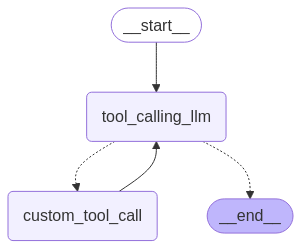

In [456]:
from langgraph.graph import MessagesState

from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    orpheus_tool_calls: List[OrpheusToolCall]

def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

def custom_tool_call(state: MessagesState):
    ai_message = state['messages'][-1]
    tool_schema = get_tool_schema(ai_message)
    dummy_output_message = mock_tool_call(tool_schema)
    json_tool_output = get_json_tool_output(dummy_output_message)
    tool_message = get_tool_message(ai_message, dummy_output_message)
    orpheus_tool_call = get_orpheus_tool_call(ai_message, json_tool_output)
    current_orpheus_tool_call = state.orpheus_tool_calls if state and hasattr(state, 'orpheus_tool_calls') else []
    return {"messages":[tool_message], "orpheus_tool_calls": current_orpheus_tool_call + [orpheus_tool_call]}

def is_tool_call(state) -> Literal["custom_tool_call", END]:
    latest_message = state['messages'][-1]
    if latest_message.tool_calls:
        return "custom_tool_call"
    return END
    

builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("custom_tool_call", custom_tool_call)
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", is_tool_call)
builder.add_edge("custom_tool_call", "tool_calling_llm")
graph = builder.compile()
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [461]:

system_prompt = [SystemMessage(content="""
You are an assistant for orchestration scraping or other long running tasks.

You need to understand the users input and use the appropriate scraper to fetch the desired information. 
In some cases it will require more than one scraper to get the desired results.
Users might ask for a specific amount of data, if insufficient data is present that is not a problem. Do not mention it to the user.

The user query is:

""")]
messages = [HumanMessage(content="Can you get price and rating info from https://www.amazon.in/gp/browse.html?node=1968126031&ref_=nav_em_sbc_mfashion_innerwear_0_2_10_6 a 100 products should do",name="Puneet")]
state = graph.invoke(
    {"messages":system_prompt+messages},
    config={"max_iterations": 10}
)

In [462]:
for i in state['messages']:
    pprint(i)
    print("""
    
    ===============
    
    """)

SystemMessage(content='\nYou are an assistant for orchestration scraping or other long running tasks.\n\nYou need to understand the users input and use the appropriate scraper to fetch the desired information. \nIn some cases it will require more than one scraper to get the desired results.\nUsers might ask for a specific amount of data, if insufficient data is present that is not a problem. Do not mention it to the user.\n\nThe user query is:\n\n', additional_kwargs={}, response_metadata={}, id='a9601126-0da9-4ecb-9e7c-95841d21f6c8')

    
    
    
HumanMessage(content='Can you get price and rating info from https://www.amazon.in/gp/browse.html?node=1968126031&ref_=nav_em_sbc_mfashion_innerwear_0_2_10_6 a 100 products should do', additional_kwargs={}, response_metadata={}, name='Puneet', id='104004fb-c71e-41f1-b5ee-514ea9a7b7a9')

    
    
    
AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_eDn4cWBwP8wjtukMTc9xgMjY', 'function': {'arguments': '{"item":{"product